In [1]:
%config InlineBackend.figure_format="retina"
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt
from importlib import reload
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

In [2]:
from backtester.datahandler import HistoricalOptionsData
from backtester.strategy import Strategy, StrategyLeg
from backtester.option import Type, Direction
from backtester import Backtest

In [3]:
# Original data
data = HistoricalOptionsData("allspx/options_data_v2_clean_compressed.h5", key="/SPX")
schema = data.schema

In [4]:
# Cleaned up data
data = HistoricalOptionsData("allspx/options_data_v2_pruned_compressed.h5", key="/SPX")
schema = data.schema

In [5]:
data._data = data._data[(data._data['quotedate'] >= '2006-12-06') & (data._data['quotedate'] <= '2015-08-21')]

We run the backtest on the date range above to compare with [this backtest.](http://dtr-trading.blogspot.com/p/spx-straddle-articles.html) We do the comparison with a [short (ATM) straddle](https://www.investopedia.com/terms/s/shortstraddle.asp) 45 DTE. Essentially the strategy consists of selling both a call and a put with (approximately) the same strike and expiration date, profiting if the underlying asset's price does not move very much. 

To run the backtest monthly, use the boolean parameter *monthly* on the *run* method (False by default).

In [6]:
# Short ATM straddle
short_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 2)

short_straddle.add_legs([leg1, leg2])
# Exit thresholds: we exit if the loss or profit on the investment on an entry is greater than 25%.
short_straddle.exit_thresholds = (0.25, 0.25)

In [7]:
bt = Backtest(capital = 0)
bt.strategy = short_straddle
bt.data = data
bt.stop_if_broke = False

In [8]:
bt.run(monthly=False)

leg_1                                               \
                contract underlying expiration  type  strike     cost   
0     SXZ070120C01480000        SPX 2007-01-20  call  1480.0    -85.0   
1     SXZ070120C01480000        SPX 2007-01-20  call  1480.0    125.0   
2     SXZ070120C01475000        SPX 2007-01-20  call  1475.0   -130.0   
3     SXZ070120C01435000        SPX 2007-01-20  call  1435.0   -980.0   
4     SXZ070120C01440000        SPX 2007-01-20  call  1440.0   -870.0   
...                  ...        ...        ...   ...     ...      ...   
1336  SPX150821C01975000        SPX 2015-08-21  call  1975.0  10390.0   
1337  SPX150821C01965000        SPX 2015-08-21  call  1965.0  11390.0   
1338  SPX150821C01980000        SPX 2015-08-21  call  1980.0   9890.0   
1339  SPX150918C02005000        SPX 2015-09-18  call  2005.0   5680.0   
1340  SPX150918C02180000        SPX 2015-09-18  call  2180.0     60.0   

                                    leg_2                                     \
           date order            contract underlying expiration type  strike   
0    2006-12-06   STO  SXZ070120P01410000        SPX 2007-01-20  put  1410.0   
1    2006-12-07   BTC  SXZ070120P01410000        SPX 2007-01-20  put  1410.0   
2    2006-12-07   STO  SXY070120P01395000        SPX 2007-01-20  put  1395.0   
3    2006-12-08   STO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
4    2006-12-11   STO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
...         ...   ...                 ...        ...        ...  ...     ...   
1336 2015-08-19   BTC  SPX150821P01975000        SPX 2015-08-21  put  1975.0   
1337 2015-08-19   BTC  SPX150821P01965000        SPX 2015-08-21  put  1965.0   
1338 2015-08-19   BTC  SPX150821P01980000        SPX 2015-08-21  put  1980.0   
1339 2015-08-20   BTC  SPX150918P02015000        SPX 2015-09-18  put  2015.0   
1340 2015-08-20   BTC  SPX150918P02205000        SPX 2015-09-18  put  2205.0   

                                 totals  
         cost       date order     cost  
0     -1490.0 2006-12-06   STO  -1575.0  
1      1990.0 2006-12-07   BTC   2115.0  
2     -1380.0 2006-12-07   STO  -1510.0  
3      -430.0 2006-12-08   STO  -1410.0  
4      -350.0 2006-12-11   STO  -1220.0  
...       ...        ...   ...      ...  
1336     20.0 2015-08-19   BTC  10410.0  
1337     20.0 2015-08-19   BTC  11410.0  
1338     20.0 2015-08-19   BTC   9910.0  
1339   3460.0 2015-08-20   BTC   9140.0  
1340  17780.0 2015-08-20   BTC  17840.0  

[1341 rows x 17 columns]

/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


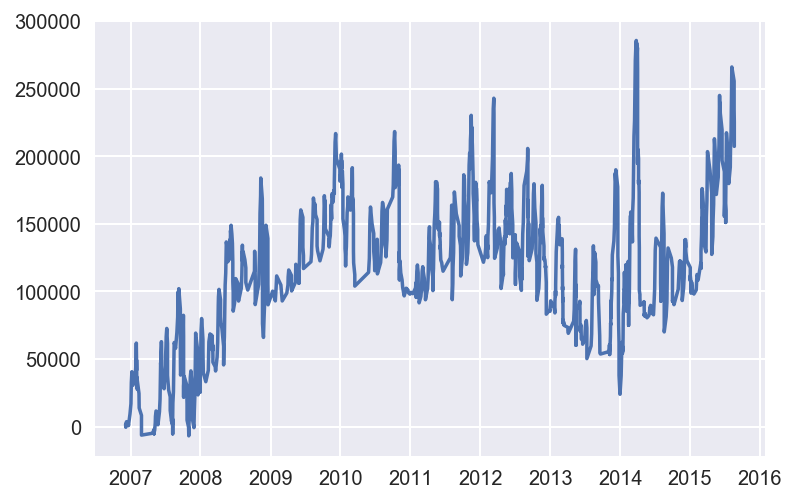

In [9]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);

We now run a [long (ATM) straddle](https://www.investopedia.com/terms/l/longstraddle.asp) 45 DTE. This is the opposite of the previous strategy, where we enter buying the contracts instead of selling, and therefore profit from big movements in the underlying asset's price. 

In [10]:
# Long (ATM) straddle
long_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg2.exit_filter = (schema.dte <= 2)

long_straddle.add_legs([leg1, leg2])
long_straddle.add_condition(['strike'])
long_straddle.exit_thresholds = (0.25, 0.25)

In [11]:
bt = Backtest(capital = 0)
bt.strategy = long_straddle
bt.data = data
bt.stop_if_broke = False

In [12]:
bt.run(monthly=False)

leg_1                                                    \
                contract    cost       date expiration order  strike  type   
0     SXZ070120C01435000  1230.0 2006-12-06 2007-01-20   BTO  1435.0  call   
1     SXZ070120C01440000   930.0 2006-12-07 2007-01-20   BTO  1440.0  call   
2     SXZ070120C01450000   570.0 2006-12-08 2007-01-20   BTO  1450.0  call   
3     SXZ070120C01465000   280.0 2006-12-11 2007-01-20   BTO  1465.0  call   
4     SXZ070120C01435000 -1220.0 2006-12-14 2007-01-20   STC  1435.0  call   
...                  ...     ...        ...        ...   ...     ...   ...   
1273  SPX150918C02115000  -410.0 2015-08-20 2015-09-18   STC  2115.0  call   
1274  SPX150918C02125000  -255.0 2015-08-20 2015-09-18   STC  2125.0  call   
1275  SPX150918C02100000  -260.0 2015-08-21 2015-09-18   STC  2100.0  call   
1276  SPX150918C02105000  -210.0 2015-08-21 2015-09-18   STC  2105.0  call   
1277  SPX150918C02095000  -300.0 2015-08-21 2015-09-18   STC  2095.0  call   

                              leg_2                                       \
     underlying            contract     cost       date expiration order   
0           SPX  SXZ070120P01435000   2720.0 2006-12-06 2007-01-20   BTO   
1           SPX  SXZ070120P01440000   3520.0 2006-12-07 2007-01-20   BTO   
2           SPX  SXZ070120P01450000   4060.0 2006-12-08 2007-01-20   BTO   
3           SPX  SXZ070120P01465000   4800.0 2006-12-11 2007-01-20   BTO   
4           SPX  SXZ070120P01435000  -1690.0 2006-12-14 2007-01-20   STC   
...         ...                 ...      ...        ...        ...   ...   
1273        SPX  SPX150918P02115000  -8650.0 2015-08-20 2015-09-18   STC   
1274        SPX  SPX150918P02125000  -9500.0 2015-08-20 2015-09-18   STC   
1275        SPX  SPX150918P02100000 -12820.0 2015-08-21 2015-09-18   STC   
1276        SPX  SPX150918P02105000 -13270.0 2015-08-21 2015-09-18   STC   
1277        SPX  SPX150918P02095000 -12380.0 2015-08-21 2015-09-18   STC   

                               totals  
      strike type underlying     cost  
0     1435.0  put        SPX   3950.0  
1     1440.0  put        SPX   4450.0  
2     1450.0  put        SPX   4630.0  
3     1465.0  put        SPX   5080.0  
4     1435.0  put        SPX  -2910.0  
...      ...  ...        ...      ...  
1273  2115.0  put        SPX  -9060.0  
1274  2125.0  put        SPX  -9755.0  
1275  2100.0  put        SPX -13080.0  
1276  2105.0  put        SPX -13480.0  
1277  2095.0  put        SPX -12680.0  

[1278 rows x 17 columns]

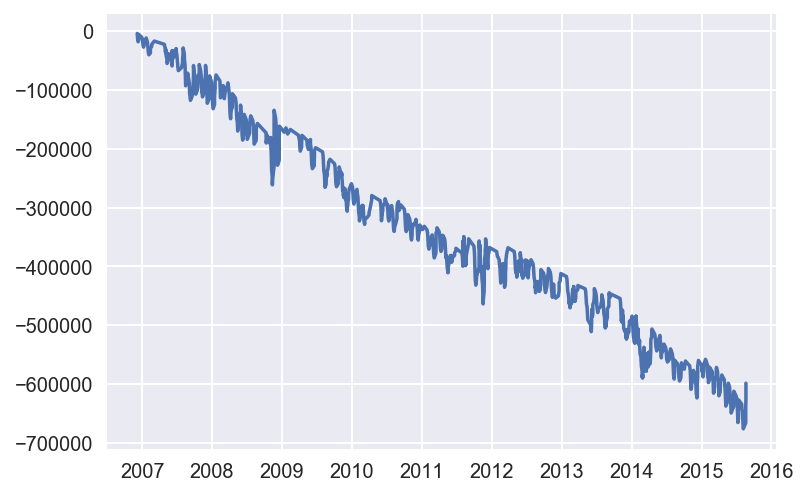

In [13]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);

Finally we run an [iron condor](https://www.investopedia.com/terms/i/ironcondor.asp).

In [14]:
# Iron Condor
iron_condor = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.PUT, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= 0.85 * schema.underlying_last)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 0.90 * schema.underlying_last) & (schema.strike <= schema.underlying_last)
leg2.exit_filter = (schema.dte <= 2)

leg3 = StrategyLeg("leg_3", schema, option_type=Type.CALL, direction=Direction.SELL)
leg3.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last) & (schema.strike <= 1.10 * schema.underlying_last)
leg3.exit_filter = (schema.dte <= 2)

leg4 = StrategyLeg("leg_4", schema, option_type=Type.PUT, direction=Direction.BUY)
leg4.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 1.15 * schema.underlying_last)
leg4.exit_filter = (schema.dte <= 2)


iron_condor.add_legs([leg1, leg2, leg3, leg4])
iron_condor.exit_thresholds = (0.25, 0.25)

In [15]:
bt = Backtest()
bt.strategy = iron_condor
bt.data = data
bt.stop_if_broke = False

In [16]:
bt.run(monthly=False)

leg_1                                                     \
               contract underlying expiration type strike  cost       date   
0    SPV090117P00200000        SPX 2009-01-17  put  200.0  35.0 2008-12-01   
1    SPV090117P00200000        SPX 2009-01-17  put  200.0  -0.0 2008-12-02   
2    SPV090117P00300000        SPX 2009-01-17  put  300.0  40.0 2008-12-02   
3    SPV090117P00300000        SPX 2009-01-17  put  300.0  -5.0 2008-12-03   
4    SPV090117P00200000        SPX 2009-01-17  put  200.0  40.0 2008-12-04   
..                  ...        ...        ...  ...    ...   ...        ...   
546  SPX150821P00800000        SPX 2015-08-21  put  800.0  -0.0 2015-08-19   
547  SPX150918P00500000        SPX 2015-09-18  put  500.0  -0.0 2015-08-20   
548  SPX150918P00600000        SPX 2015-09-18  put  600.0  -0.0 2015-08-21   
549  SPX150918P00700000        SPX 2015-09-18  put  700.0  -0.0 2015-08-21   
550  SPX150918P00825000        SPX 2015-09-18  put  825.0  -0.0 2015-08-21   

                        leg_2             ... leg_3               leg_4  \
    order            contract underlying  ... order            contract   
0     BTO  SPZ090117P00740000        SPX  ...   STO  SXB090117P00940000   
1     STC  SPZ090117P00740000        SPX  ...   BTC  SXB090117P00940000   
2     BTO  SPZ090117P00765000        SPX  ...   STO  SXB090117P00980000   
3     STC  SPZ090117P00765000        SPX  ...   BTC  SXB090117P00980000   
4     BTO  SPZ090117P00765000        SPX  ...   STO  SXB090117P00975000   
..    ...                 ...        ...  ...   ...                 ...   
546   STC  SPX150821P01845000        SPX  ...   BTC  SPX150821P02600000   
547   STC  SPX150918P01900000        SPX  ...   BTC  SPX150918P02450000   
548   STC  SPX150918P01895000        SPX  ...   BTC  SPX150918P02500000   
549   STC  SPX150918P01890000        SPX  ...   BTC  SPX150918P02550000   
550   STC  SPX150918P01880000        SPX  ...   BTC  SPX150918P02400000   

                                                                   totals  
    underlying expiration type  strike     cost       date order     cost  
0          SPX 2009-01-17  put   940.0  14740.0 2008-12-01   BTO   5325.0  
1          SPX 2009-01-17  put   940.0 -11750.0 2008-12-02   STC  -1520.0  
2          SPX 2009-01-17  put   980.0  14870.0 2008-12-02   BTO   4830.0  
3          SPX 2009-01-17  put   980.0 -13250.0 2008-12-03   STC  -2315.0  
4          SPX 2009-01-17  put   975.0  14870.0 2008-12-04   BTO   4880.0  
..         ...        ...  ...     ...      ...        ...   ...      ...  
546        SPX 2015-08-21  put  2600.0 -52120.0 2015-08-19   STC -49045.0  
547        SPX 2015-09-18  put  2450.0 -41660.0 2015-08-20   STC -39960.0  
548        SPX 2015-09-18  put  2500.0 -52480.0 2015-08-21   STC -49100.0  
549        SPX 2015-09-18  put  2550.0 -57480.0 2015-08-21   STC -54100.0  
550        SPX 2015-09-18  put  2400.0 -42490.0 2015-08-21   STC -39160.0  

[551 rows x 33 columns]

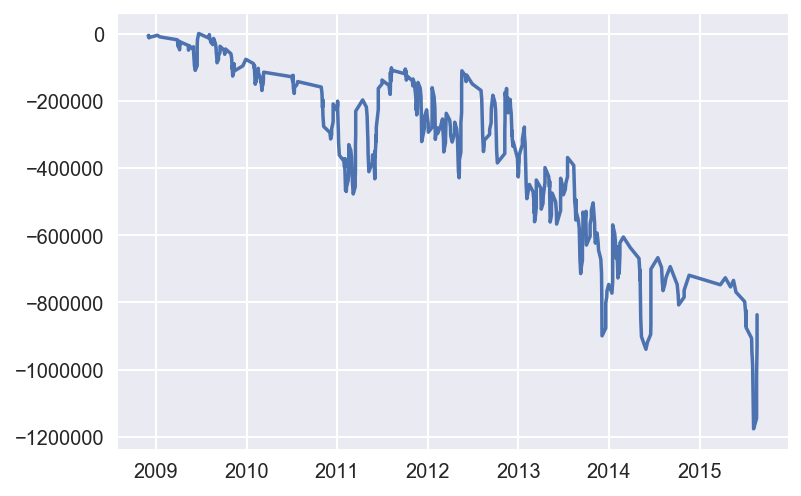

In [17]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);